In [1]:
# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [5]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

cuda = torch.device('cuda')

train_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(subj.T).float().cuda() for subj in test_rest_ts]

# print(train_rest_ts_torch[0].device)
print(train_rest_ts_torch[0].shape)
print('Complete')

torch.Size([210, 264])
Complete


In [35]:
import torch

torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('Total: {:f} Reserved: {:f} Allocated: {:f} Free: {:f}'.format(t,r,a,f))

Total: 4294967296.000000 Reserved: 1453326336.000000 Allocated: 256159744.000000 Free: 1197166592.000000


In [32]:
import math

nt = train_rest_ts_torch[0].shape[0]
nroi = train_rest_ts_torch[0].shape[1]
nBatch = 10
nc = 8
sz1 = math.floor((nt-4-5)/2+1)
sz2 = math.floor((nt-8-5)/2+1)

class CNNGRU(nn.Module):
    def __init__(self):
        super(CNNGRU, self).__init__()
        self.conv1 = nn.Conv2d(1,nc,(5,1)).cuda() # Output size (nt-4)x1
#         self.conv2 = nn.Conv2d(1,nc,(9,nroi)).cuda() # Output size (nt-8)x1
#         self.mp1 = nn.MaxPool2d((5,1),(2,1)) # Output size (A-10)/5+1)x1 
        self.gru1 = nn.GRU(input_size=nroi*nc, hidden_size=20, batch_first=True).cuda()
        self.fc1 = nn.Linear(20,100).cuda()
        self.fc2 = nn.Linear(100,1).cuda()
        
    def forward(self, x):
        nb = x.shape[0]
        x = x.unsqueeze(1)
#         a = self.mp1(F.relu(self.conv1(x)))
#         b = self.mp1(F.relu(self.conv2(x)))
#         x = torch.cat((a,b),dim=2)
#         x = x.squeeze(3)
        x = F.relu(self.conv1(x))
        x = x.permute(0,2,1,3)
        x = x.reshape([nb,nt-4,nroi*nc])
#         x = x.permute(0,2,1)
        _,x = self.gru1(x)
        x = x.permute(1,0,2)
        x = x.reshape([nb,20])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
cnngru = CNNGRU()
optimcnn = torch.optim.Adam(cnngru.parameters(), lr=1e-3)

print('Complete')

Complete


In [33]:
# Train CNN

import random

N = len(train_rest_ts_torch)
running = 0
nEpoch = 2000
pPeriod = 200

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_rest_ts_torch[idx]
        batch.append(subj)
        truth[i] = y_train[idx,0]
    batch = torch.stack(batch,dim=0)
    optimcnn.zero_grad()
    pred = cnngru(batch).flatten()
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    running += loss.cpu()
    optimcnn.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=346637.937500
epoch 200 loss=270269.062500
epoch 400 loss=53622.230469
epoch 600 loss=15209.705078
epoch 800 loss=14075.705078
epoch 1000 loss=12090.202148
epoch 1200 loss=7030.073730
epoch 1400 loss=3138.870117
epoch 1600 loss=1334.794067
epoch 1800 loss=629.838501
epoch 1999 loss=413.172821
Finished training


[[1.         0.35514674]
 [0.35514674 1.        ]]
3.3985230573381817
2.7159380635907575


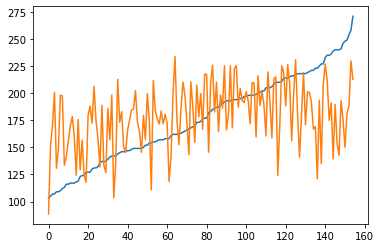

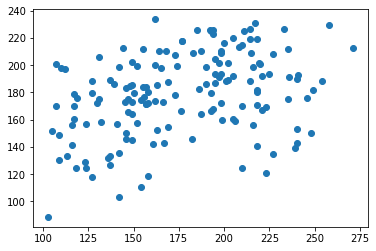

In [34]:
import matplotlib.pyplot as plt

y = y_test.flatten()
X = []

for subj in test_rest_ts_torch:
    X.append(subj)
    
X = torch.stack(X, dim=0)
yPred = cnngru(X).flatten().cpu().detach().numpy()

# yPred = Xtest@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()